In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet

/var/folders/mw/2cx6x93d04g09y_zdvpb9vpc0000gn/T/ipykernel_73982/1571553176.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_timeseries['Date'] = pd.to_datetime(df_timeseries['Date'])


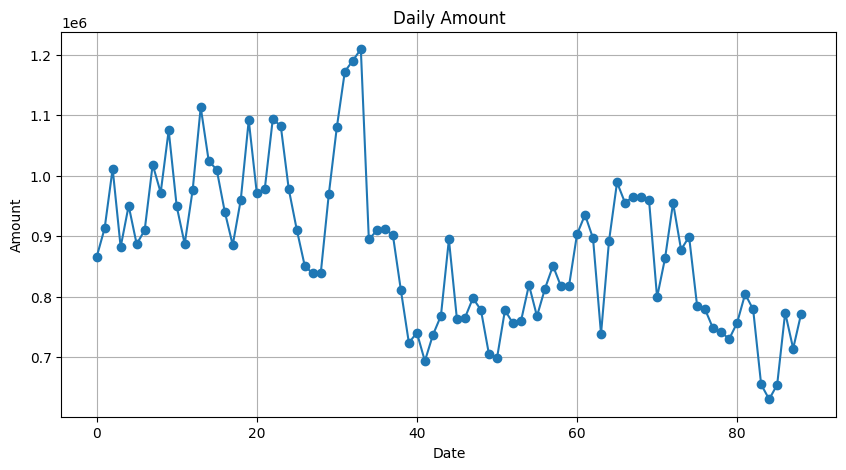

In [5]:
# Load DataFrame
df = pd.read_excel('./AmazonSaleReport.xlsx') 
df_timeseries = df[['Date', 'Amount']] 

# Transform date into datetime object
df_timeseries['Date'] = pd.to_datetime(df_timeseries['Date'])

# Set Date as Index
df_timeseries.set_index('Date', inplace=True)

# Resample DataFrame
df_resampled = df_timeseries.resample('D').sum()  # Resample by day and sum the 'Amount' column

# exclude the first and last date
df_resampled = df_resampled[1:-1]
df_resampled.reset_index(inplace=True)

# Plot the resampled data
plt.figure(figsize=(10, 5))
plt.plot(df_resampled.index, df_resampled['Amount'], marker='o')
plt.title('Daily Amount')
plt.xlabel('Date')
plt.ylabel('Amount')
plt.grid(True)
plt.show()

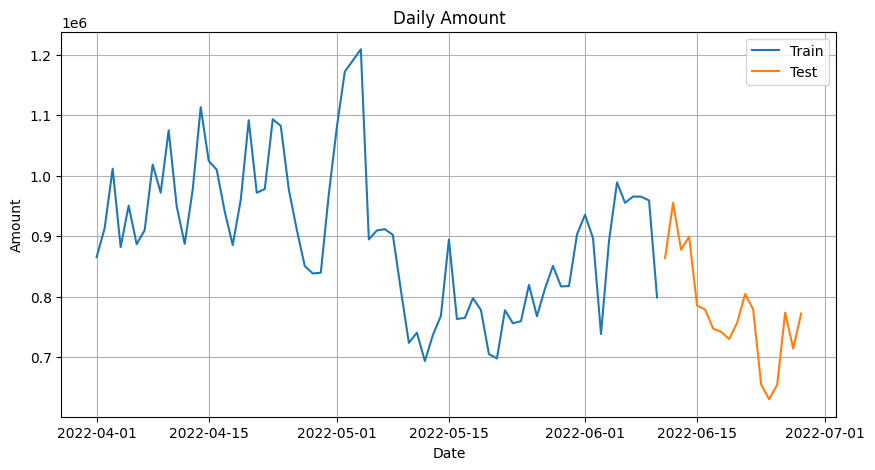

In [6]:
# Split the data into training and testing sets
# 80% for training, 20% for testing
# We do not shuffle the data because the order is important in time series
train_size = int(len(df_resampled) * 0.8)  # 80% for training, 20% for testing
train, test = df_resampled.iloc[:train_size], df_resampled.iloc[train_size:]

# Plot the train vs the test data
plt.figure(figsize=(10, 5))
plt.plot(train['Date'], train['Amount'], label='Train')
plt.plot(test['Date'], test['Amount'], label='Test')
plt.title('Daily Amount')
plt.xlabel('Date')
plt.ylabel('Amount')
plt.grid(True)
plt.legend()
plt.show()

In [7]:
# How many days are in the test set?
print(f'Test set has {len(test)} days')

Test set has 18 days


22:30:04 - cmdstanpy - INFO - Chain [1] start processing
22:30:04 - cmdstanpy - INFO - Chain [1] done processing


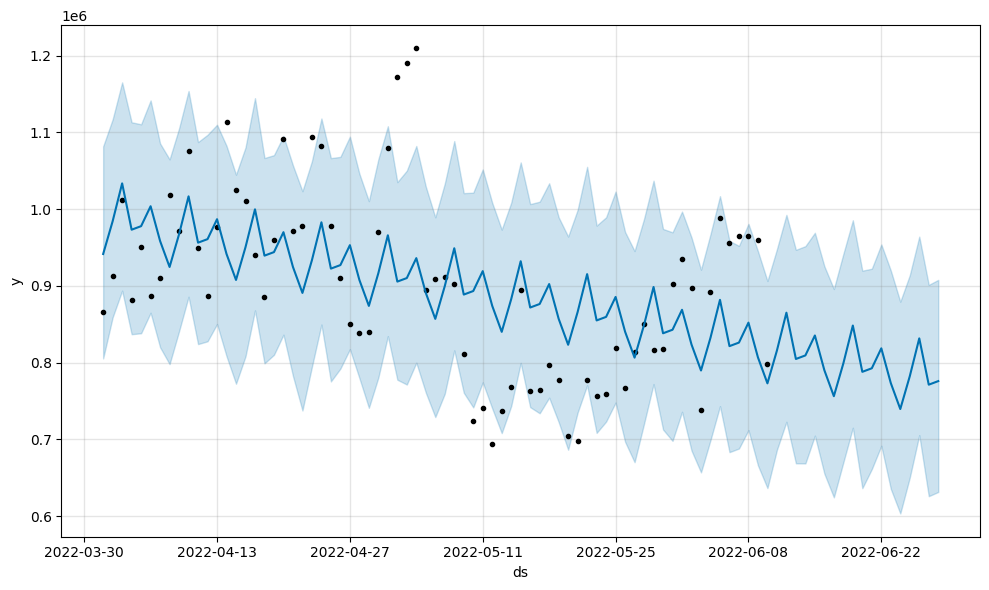

In [9]:

# Prepare the data for Prophet
df = train.copy()
df.columns = ['ds', 'y']  # Prophet requires columns to be named 'ds' and 'y'

# Initialize and fit the model
model = Prophet()
model.fit(df)

# Create a dataframe to hold predictions
future = model.make_future_dataframe(periods=18, freq ='D')  # Predicting for the next 365 days daily
forecast = model.predict(future)

# Plot the forecast
fig = model.plot(forecast)

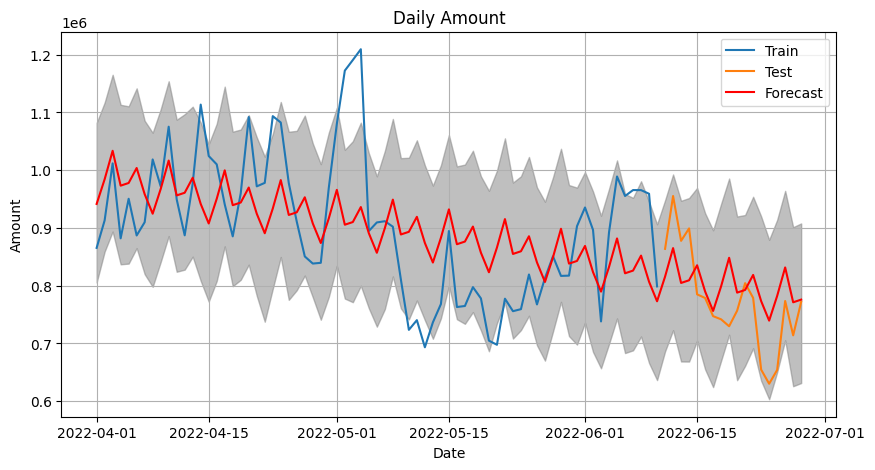

In [10]:
# Compare the forecast with the test data
plt.figure(figsize=(10, 5))
plt.plot(train['Date'], train['Amount'], label='Train')
plt.plot(test['Date'], test['Amount'], label='Test')
plt.plot(forecast['ds'], forecast['yhat'], label='Forecast', color='red')
plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='gray', alpha=0.5)
plt.title('Daily Amount')
plt.xlabel('Date')
plt.ylabel('Amount')
plt.grid(True)
plt.legend()
plt.show()


In [11]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Evaluate the model
# Merge the forecast with the test data
test_forecast = forecast.set_index('ds').join(test.set_index('Date'))

# Calculate MAE and RMSE
mae = mean_absolute_error(test_forecast['Amount'], test_forecast['yhat'])
rmse = mean_squared_error(test_forecast['Amount'], test_forecast['yhat'], squared=False)

print(f'Mean Absolute Error (MAE): {mae}')
print(f'Root Mean Squared Error (RMSE): {rmse}')

ValueError: Input contains NaN.